# Mall customers

### Objectives

### Description of the data

Data obtained from Kaggle:``https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python``.

In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
filepath = 'data/Mall_Customers.csv'
data = pd.read_csv(filepath, sep = ',')

This is data for some customer expences in a certain mall. As observed in the following lines, we have data from the customer gender, anual income and spending score. 

In [3]:
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


The types of the features are the following:

In [4]:
print(data.info())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
(200, 5)


The only object feature is **Genre**, which is the variable **y** we will try to classify. Additionally, we have data from 200 customers, hence the shape of the dataset is (200, 5). We also observe that we do not have null data.

### Actions taken for data cleaning and feature engineering.

More or less we have the same amount of males and females.

In [5]:
target = 'Genre'
data[target].value_counts(normalize = True)

Female    0.56
Male      0.44
Name: Genre, dtype: float64

In order to apply the logistic regression, we gonna have to rescale the data. we apply the Standard Scaler.

In [6]:
from sklearn.preprocessing import StandardScaler

# we first divide the X and y 
feature_cols = [x for x in data.columns if x != 'Genre']

# ara reescalem les X
s = StandardScaler()
data[feature_cols] = s.fit_transform(data[feature_cols])

On the other hand, we need to label encode the **Genre** data.

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data[target] = le.fit_transform(data[target])

y = data[target]
X = data[feature_cols]

y.value_counts()

0    112
1     88
Name: Genre, dtype: int64

Now the data is prepared for model implementation. **Finally, we will explore the correlation between variables**. For that purpose we will remove the customer ID.


In [23]:
feature_cols_2 = [x for x in data.columns if x not in ['Genre', 'CustomerID']]

corr_values = data[feature_cols_2].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()
corr_values

,feature1,feature2,correlation,abs_correlation
0,Age,Annual Income (k$),-0.012398,0.012398
1,Age,Spending Score (1-100),-0.327227,0.327227
2,Annual Income (k$),Spending Score (1-100),0.009903,0.009903


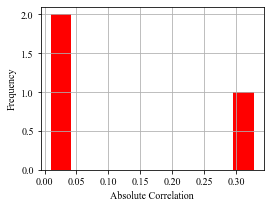

In [28]:
ax = corr_values.abs_correlation.hist(bins=10, figsize=(4, 3), color = 'red')
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [27]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=True)

,feature1,feature2,correlation,abs_correlation
1,Age,Spending Score (1-100),-0.327227,0.327227
0,Age,Annual Income (k$),-0.012398,0.012398
2,Annual Income (k$),Spending Score (1-100),0.009903,0.009903


We observe here that the highest correlation is oberved between the age and spending score, but this correlation in very low in any case.

### Training at least three different classifier models

Summary of training at least three different classifier models, preferably of different nature in explainability and predictability. For example, you can start with a simple logistic regression as a baseline, adding other models or ensemble models. Preferably, all your models use the same training and test splits, or the same cross-validation method.

### 1. Logistic regression 

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Let's split the data first:
X_train, X_test, y_train, y_test = train_test_split(data[feature_cols], data[target],
                                                   test_size=0.3, random_state=42)

# this is the standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

# Now with coress validation and regularization
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

Now we compute the prediction for these models

In [39]:
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_prob.head()

,lr,l1,l2
0,0.564986,0.5,0.500244
1,0.585346,0.5,0.500397
2,0.517272,0.5,0.500053
3,0.541887,0.5,0.500056
4,0.503785,0.5,0.500052


Predictions are obtained with uncertainty. Le'ts represent the confusion matrix:

In [41]:
from sklearn.metrics import confusion_matrix

cm = dict()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]
for lab in coeff_labels:
    cm[lab] = confusion_matrix(y_test, y_pred[lab])

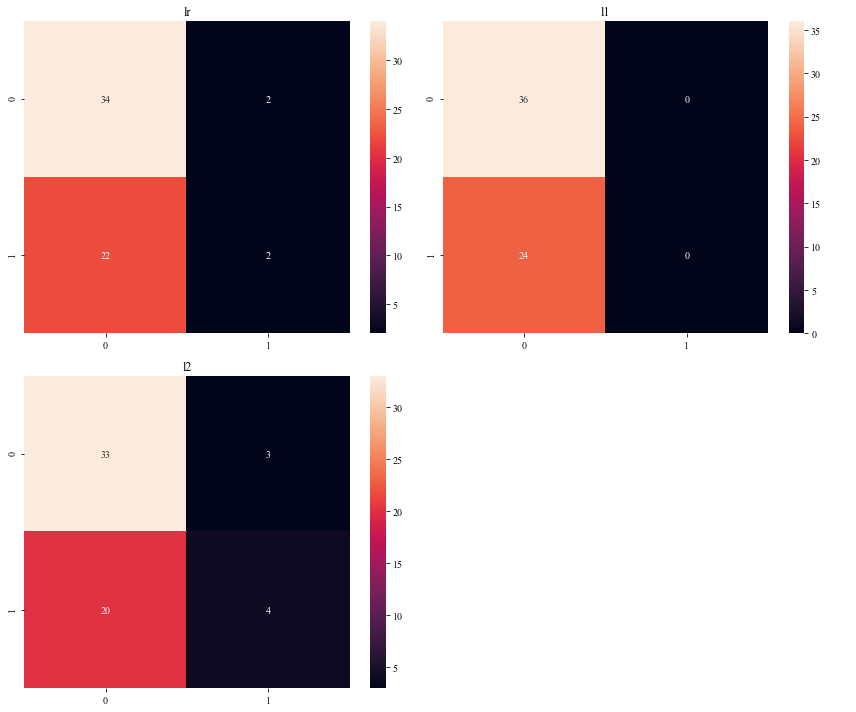

In [42]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

### Which of your classifier models you recommend

### Suggestions for next steps